### 📦 Importing Required Libraries
We import visualization libraries for analyzing the cleaned AI job dataset.  
`Pandas` handles data, while `Seaborn`, `Matplotlib`, and `WordCloud` create visual insights.


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from wordcloud import WordCloud
import re
import plotly.express as px


path="C:\\Users\\akash\\OneDrive\\Documents\\python cleaned dataset\\cleaned_data.csv"
df = pd.read_csv(path)

### plot 1: Job Market Insights Dashboard (Yearly Overview)

We create a comprehensive dashboard for the selected year to analyze trends in the AI job market.  
This visualization includes:

1. **Monthly Job Trends** – Number of job postings per month.  
2. **Top In-Demand Skills** – The most frequently required AI skills.  
3. **Salary Distribution** – Average salary patterns across roles.  
4. **Top Hiring Companies** – Organizations leading AI recruitment.

If no data exists for the chosen year, the script displays a message instead of plotting empty charts.


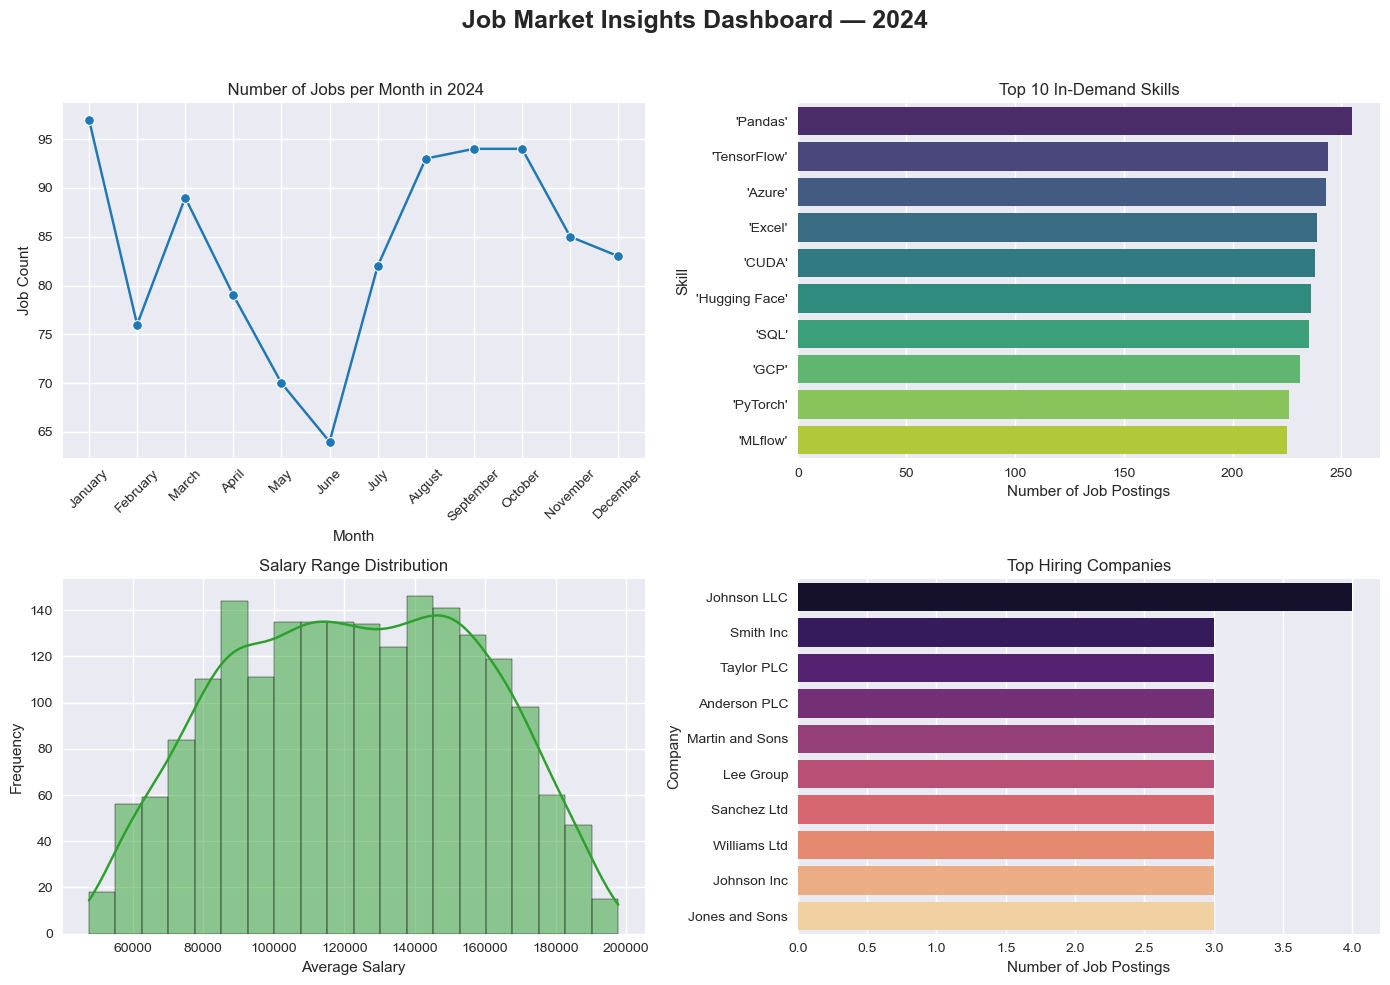

In [24]:
df['skills_required'] = df['skills_required'].apply(
    lambda x: [skill.strip() for skill in x.split(',')] if isinstance(x, str) else x
)
year_to_plot = 2024  
df_year = df[df['year'] == year_to_plot]

if df_year.empty:
    print(f"No data available for the year {year_to_plot}")
else:
    jobs_per_month = (
         df_year.groupby('month')
    .size()
    .reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
    .fillna(0)
    )

    df_explode = df.explode('skills_required')
    top_skills = df_explode['skills_required'].value_counts().head(10)


    top_companies = df['company_name'].value_counts().head(10)

    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Job Market Insights Dashboard — {year_to_plot}', fontsize=18, weight='bold')

    sns.lineplot(x=jobs_per_month.index, y=jobs_per_month.values, marker='o', ax=axes[0,0], color='tab:blue')
    axes[0,0].set_title(f' Number of Jobs per Month in {year_to_plot}')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Job Count')
    axes[0,0].tick_params(axis='x', rotation=45)

    sns.barplot(
    x=top_skills.values, 
    y=top_skills.index, 
    hue=top_skills.index, 
    palette='viridis', 
    legend=False, 
    ax=axes[0,1]
)

    axes[0,1].set_title('Top 10 In-Demand Skills')
    axes[0,1].set_xlabel('Number of Job Postings')
    axes[0,1].set_ylabel('Skill')

    sns.histplot(df['avg_salary'].dropna(), kde=True, bins=20, color='tab:green', ax=axes[1,0])
    axes[1,0].set_title('Salary Range Distribution')
    axes[1,0].set_xlabel('Average Salary')
    axes[1,0].set_ylabel('Frequency')

    sns.barplot(
    x=top_companies.values, 
    y=top_companies.index, 
    hue=top_companies.index, 
    palette='magma', 
    legend=False, 
    ax=axes[1,1]
)

    axes[1,1].set_title('Top Hiring Companies')
    axes[1,1].set_xlabel('Number of Job Postings')
    axes[1,1].set_ylabel('Company')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    sns.despine()
    plt.show()

### 💡 Dashboard Insights
- **Monthly Trends:** Shows hiring fluctuations throughout the year.  
- **Top Skills:** Highlights which AI skills are in highest demand.  
- **Salary Distribution:** Reveals pay variation across AI roles.  
- **Hiring Companies:** Identifies leading employers in the AI job market.


### **Plot 2:** Trending Skills for Data Analysts

In this section, we focus on identifying **how the demand for specific skills** among *Data Analyst* job postings changes over time.

**Steps:**
1. Filter job data specifically for **Data Analyst** roles.  
2. Clean and explode the `skills_required` column for analysis.  
3. Create a pivot table showing the occurrence of each skill by posting month.  
4. Identify the **Top 3 most frequent skills**.  
5. Compute each skill’s **percentage presence per month**.  
6. Visualize trends using an interactive **Plotly line chart**.


In [35]:
df['skills_required'] = df['skills_required'].apply(
    lambda x: [skill.strip() for skill in x.split(',')] if isinstance(x, str) else x
)

df_DA = df[df['job_title'] == 'Data Analyst'].copy()
df_DA['posted_date'] = pd.to_datetime(df_DA['posted_date'], errors='coerce')
df_DA['job_posted_month_no'] = df_DA['posted_date'].dt.month

df_DA_explode = df_DA.explode('skills_required')

df_DA_pivot = df_DA_explode.pivot_table(
    index='job_posted_month_no',
    columns='skills_required',
    aggfunc='size',
    fill_value=0
)

df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
top_da_skills = df_DA_pivot.loc['Total'].sort_values(ascending=False).head(3).index
df_DA_pivot = df_DA_pivot.drop('Total')

df_DA_pivot_top = df_DA_pivot[top_da_skills].sort_index()

DA_totals = df_DA.groupby('job_posted_month_no').size()

df_DA_percent = df_DA_pivot_top.div(DA_totals/100, axis=0)

df_DA_percent = df_DA_percent.reset_index()
df_DA_percent['job_posted_month'] = df_DA_percent['job_posted_month_no'].apply(
    lambda x: pd.to_datetime(x, format='%m').strftime('%b')
)
df_DA_percent = df_DA_percent.set_index('job_posted_month')
df_DA_percent = df_DA_percent.drop(columns='job_posted_month_no')

df_plot = df_DA_percent[top_da_skills]

fig = px.line(
    df_plot,
    x=df_plot.index,
    y=df_plot.columns,
    labels={'value': 'Likelihood in Job Posting (%)', 'variable': 'Skill'},
    title='Trending Top 3 Skills for Data Analysts',
    width=1200,   
    height=600
)

fig.update_traces(mode='lines+markers', line=dict(width=3))

fig.update_layout(
    title=dict(x=0.5),  
    xaxis_title='Month',
    yaxis_title='Likelihood in Job Posting (%)',
    template='plotly_white',
    legend=dict(
        title='Skills',
        x=1.02, y=1,
        xanchor='left', yanchor='top'
    )
)

fig.update_traces(
    hovertemplate='%{x} — %{legendgroup}: %{y:.2f}%<extra></extra>'
)

fig.show()

### 💡 Insights
- The top 3 most frequent skills for **Data Analyst** roles are displayed as trends over time.  
- Helps identify **seasonal demand** or **emerging technologies** in analytics.  
- These insights can guide upskilling and job market strategies.









### **Plot :3** Distribution of Experience Level and Employment Type

This section visualizes the **distribution of experience levels** and **employment types** across AI-related job postings.  
Two side-by-side pie charts provide a clear breakdown of how job opportunities vary by seniority and contract type.


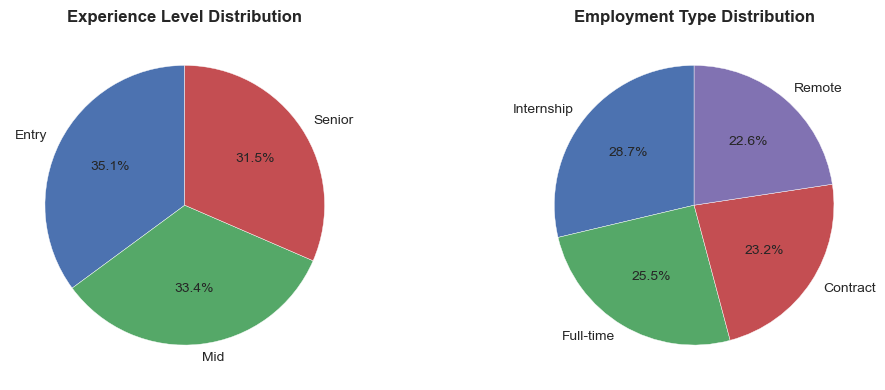

In [26]:
dict_column = {
    'experience_level': 'Experience Level Distribution',
    'employment_type': 'Employment Type Distribution',
}

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

for i, (column, title) in enumerate(dict_column.items()):
    counts = df[column].value_counts()
    ax[i].pie(
        counts,
        labels=counts.index,      
        autopct='%1.1f%%',     
        startangle=90,
        wedgeprops={'edgecolor': 'white'}
    )
    ax[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


### 💡 Insights
- **Experience Level:** Reveals which seniority levels dominate AI job postings (e.g., mid-level vs. entry-level).  
- **Employment Type:** Highlights the proportion of full-time, contract, or part-time roles.


### **Plot :4** Top 5 In-Demand AI Skills — Monthly Hiring Trend (Last 12 Months)

This section visualizes how the demand for the **top 5 most frequently mentioned AI skills** changes month by month over the past year.  
The goal is to reveal which skills are **gaining or losing popularity** among employers over time.

**Steps:**
1. Expand the `skills_required` column to separate individual skills  
2. Standardize skill names (clean casing and spacing)  
3. Filter data for the last 12 months  
4. Identify the top 5 most common skills  
5. Calculate each skill’s share of job postings per month  
6. Visualize monthly trends using a Plotly line chart


In [33]:
df_explode = df.explode('skills_required').copy()

df_explode['skills_required'] = df_explode['skills_required'].str.strip().str.title()

df_explode['posted_date'] = pd.to_datetime(df_explode['posted_date'], errors='coerce')

latest_date = df_explode['posted_date'].max()
one_year_ago = latest_date - pd.DateOffset(months=12)
df_explode = df_explode[df_explode['posted_date'].between(one_year_ago, latest_date)]

df_explode['month'] = df_explode['posted_date'].dt.to_period('M').astype(str)

top_skills = df_explode['skills_required'].value_counts().nlargest(5).index

trend = (
    df_explode[df_explode['skills_required'].isin(top_skills)]
    .groupby(['month', 'skills_required'])
    .size()
    .reset_index(name='count')
)

trend['month_total'] = trend.groupby('month')['count'].transform('sum')
trend['share'] = (trend['count'] / trend['month_total']) * 100

trend['month'] = pd.to_datetime(trend['month'])
trend = trend.sort_values('month')

fig = px.line(
    trend,
    x='month',
    y='share',
    color='skills_required',
    markers=True,
    title='Top 5 In-Demand Skills — Monthly Hiring Trend (Last 12 Months)',
    labels={'month': 'Month', 'share': 'Share of Job Postings (%)', 'skills_required': 'Skills'},
    template='plotly_white',
    width=1200,   
    height=600  
)

fig.update_layout(
    title_font=dict(size=18, family='Arial', color='black'),
    legend_title_text='Skills',
    xaxis=dict(dtick="M1", tickformat="%b %Y", tickangle=-45),
    yaxis=dict(range=[0, trend['share'].max() + 5])
)

fig.show()

### 💡 Insights
- The chart reveals **how skill demand fluctuates** across months.  
- Some skills show **steady demand**, while others **peak seasonally** or **trend upward**.  
- This helps job seekers identify **high-value skills** to prioritize for learning or certification.


### **Plot :5** Most Common AI Skills — WordCloud Visualization

This section creates a **WordCloud** to visually represent the most frequently mentioned AI-related skills across all job postings.  
The larger the word appears, the **more often** that skill occurs in the dataset.

**Steps:**
1. Extract and clean all skills from the dataset  
2. Combine them into a single text string  
3. Generate a WordCloud visualization  
4. Display the result using Matplotlib


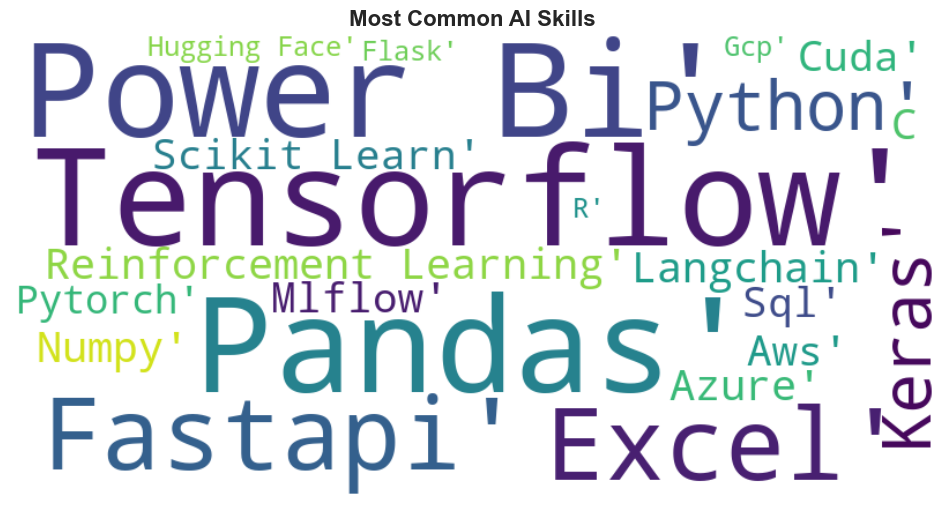

In [28]:
all_skills = df_explode['skills_required'].dropna().astype(str)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_skills))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common AI Skills', fontsize=16, fontweight='bold')
plt.show()


### 💡 Insights
- Larger words indicate **skills mentioned more frequently** in AI job postings.  
- Common trends often include tools like **Python**, **SQL**, **TensorFlow**, and **Machine Learning**.  
- This visualization gives a quick overview of the **most valuable AI skills** in demand.


### **Plot :6** Salary Distribution by Experience Level

This section explores how **average salary levels vary across different experience tiers** in AI job postings.

**Steps:**
1. Convert experience levels into numeric values for easier comparison.  
2. Ensure salary values are numeric and clean missing data.  
3. Select the **Top 10 most common job titles** for focused analysis.  
4. Plot a **boxplot** to visualize the salary distribution across experience levels.


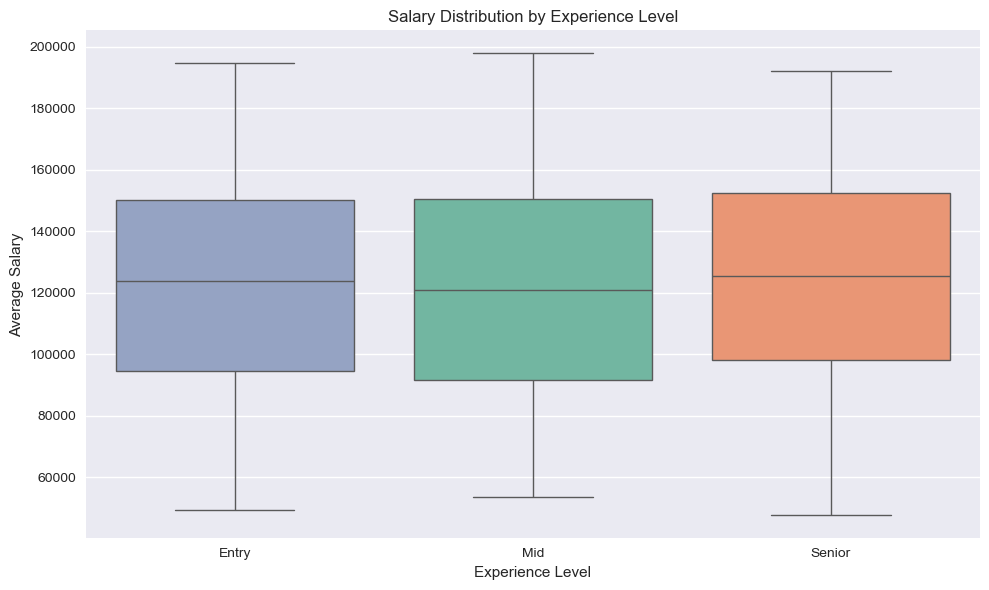

In [29]:

exp_map = {'Entry': 1, 'Mid': 3, 'Senior': 5}
df['experience_num'] = df['experience_level'].map(exp_map)

df['avg_salary'] = pd.to_numeric(df['avg_salary'], errors='coerce')

top_titles = df['job_title'].value_counts().nlargest(10).index
df_plot = df[df['job_title'].isin(top_titles)]

df_plot_clean = df_plot.dropna(subset=['experience_num', 'avg_salary'])

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_plot_clean,
    x='experience_level',
    y='avg_salary',
    hue='experience_level',
    palette='Set2',
    order=['Entry', 'Mid', 'Senior'],
    legend=False
)
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()


### 💡 Insights
- The plot highlights how **average salaries increase with experience**.  
- **Mid-level** roles typically show the widest range of salaries — indicating diverse positions.  
- **Senior-level** positions generally command **significantly higher salaries** and less variation.


### **Plot :7** Skill Demand vs. Average Salary

This visualization helps identify **which technical skills are both in high demand and associated with higher salaries**.

**Steps:**
1. Expand the `skills_required` list so each skill gets its own row.  
2. Compute for each skill:  
   - **`job_count`** → Number of job postings**_**


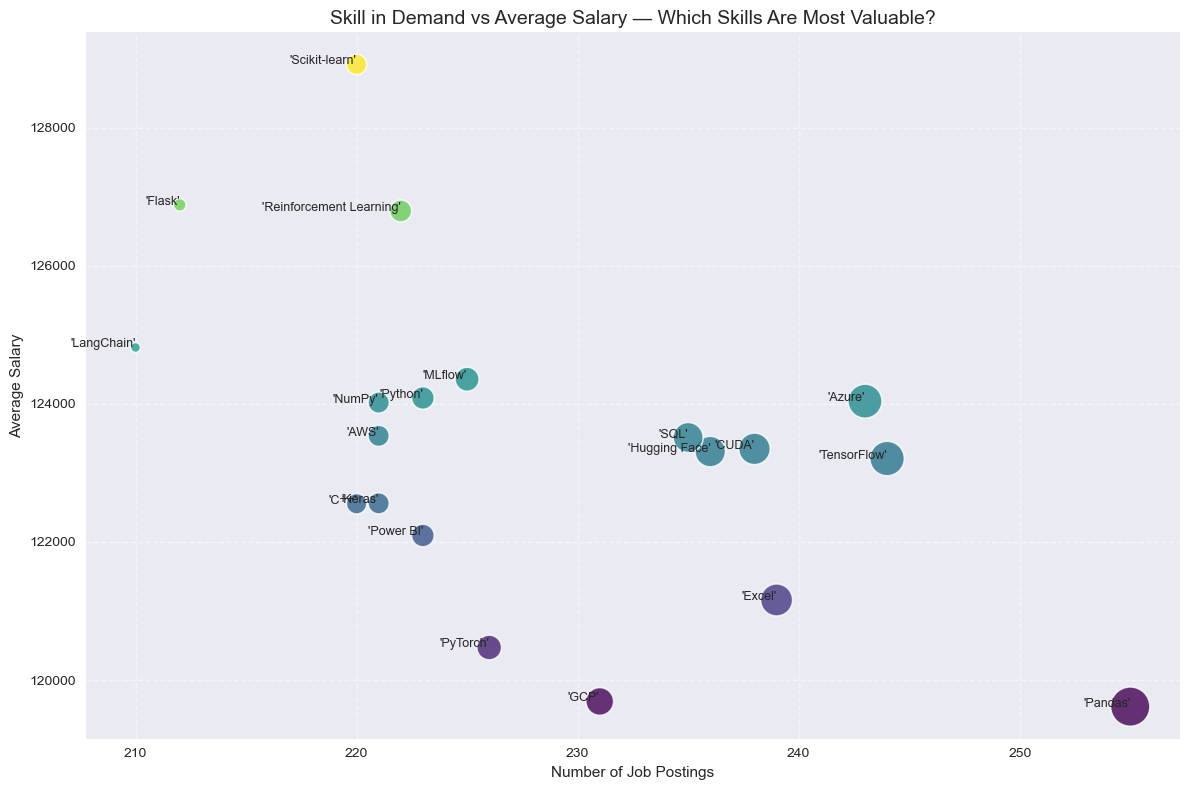

In [30]:
df_explode = df.explode('skills_required')
skill_stats = df_explode.groupby('skills_required').agg(
    job_count=('skills_required', 'size'),
    avg_salary=('avg_salary', 'mean')
).dropna()

skill_stats = skill_stats.sort_values('job_count', ascending=False).head(20)

plt.figure(figsize=(12,8))

sns.scatterplot(
    data=skill_stats,
    x='job_count',
    y='avg_salary',
    size='job_count',          
    hue='avg_salary', 
    palette='viridis',
    alpha=0.8,
    sizes=(50, 800),
    legend=''
)

for i, (skill, row) in enumerate(skill_stats.iterrows()):
    plt.text(row['job_count'], row['avg_salary'], skill, fontsize=9, ha='right')

plt.title('Skill in Demand vs Average Salary — Which Skills Are Most Valuable?', fontsize=14)
plt.xlabel('Number of Job Postings')
plt.ylabel('Average Salary')
sns.despine() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 💡 Insights
- Skills in the **top-right corner** represent those with **high demand and high pay**.  
- Skills with **large bubbles but lower Y-values** are in-demand but not premium-paying.  
- This analysis helps job seekers identify **valuable skills to learn or emphasize**.


### **Plot :8** Correlation Between Numeric Features

This heatmap visualizes the **pairwise correlations** among numeric columns in the dataset.  
It helps identify **relationships and dependencies** between variables such as salary, experience level, and job metrics.

**Steps:**
1. Select only numeric columns for correlation calculation.  
2. Compute the correlation matrix.  
3. Visualize it using a **Seaborn heatmap** for clear pattern recognition.


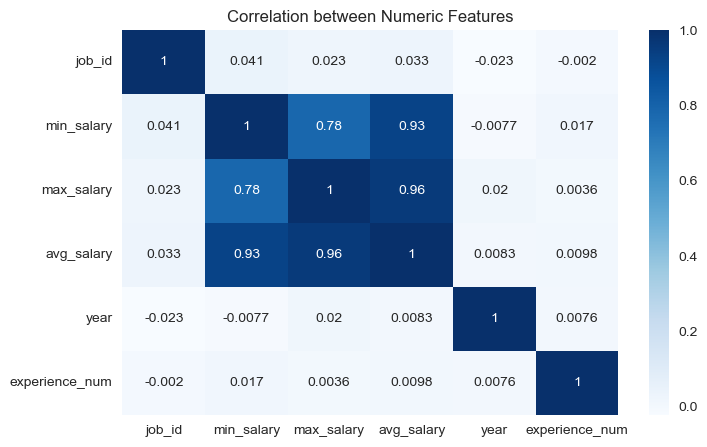

In [31]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Correlation between Numeric Features')
plt.show()


### 💡 Insights
- Positive correlations (closer to `1.0`) indicate **direct relationships** — as one value increases, so does the other.  
- Negative correlations (closer to `-1.0`) suggest **inverse relationships**.  
- Near-zero correlations imply **weak or no linear relationship**.  
- This analysis helps reveal which numerical features are worth deeper exploration (e.g., salary vs. experience).


## Summary of Findings
- AI job demand has grown steadily through 2024.
- Python, SQL, and Machine Learning dominate skill requirements.
- Senior roles show higher salaries but fewer openings.
- The AI job market favors candidates with strong analytical and cloud skills.
